## Clipped Relu

Notebook to make different subplots for the figure illustrating the basic clipped relu

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from lrr_annot.loader import Loader
from lrr_annot.analyzer import compute_winding, compute_regression, median_slope
from lrr_annot.plotter import plot_regression, plot_residue_annotations_3d

## Load in sequence, compute winding number, and compute breakpoints

In [2]:
#protid = "AT1G72840.2"
protid = "AT3G44400.1"
loader = Loader()
loader.load_single("../data/a_thaliana_other", f"{protid}.pdb")
X = loader.structures[protid]
bfactor = loader.bfactors[protid]
winding_res = compute_winding(X)
winding = winding_res["winding"]

regression_res = compute_regression(winding, n_breakpoints=2)
breakpoints = regression_res["breakpoints"]
slope = regression_res["slope"]

## Compare winding number to bandpass b-factor

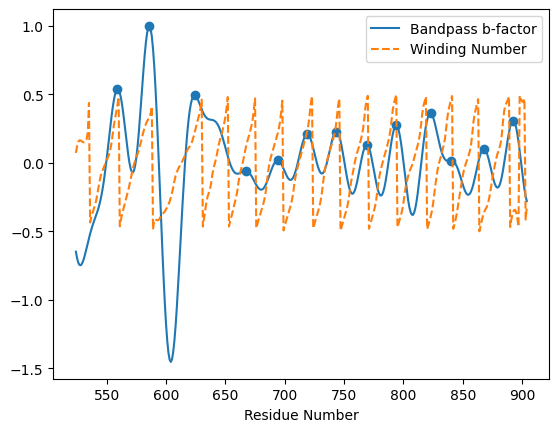

In [3]:
from scipy import signal
[a, b] = breakpoints
rg = np.arange(a, b)

period = 25

sos = signal.butter(10, [0.5/period, 2/period], 'bandpass', output='sos')
bff = signal.sosfiltfilt(sos, bfactor)
bff = bff[a:b]
bff /= np.max(bff)
idx = np.arange(1, bff.size-1)
idx = idx[(bff[idx] > bff[idx-1])*(bff[idx] > bff[idx+1])]

plt.plot(rg, bff)
plt.plot(rg, winding[rg]%1 - 0.5, linestyle='--')
plt.scatter(rg[idx], bff[idx])
plt.xlabel("Residue Number")
plt.legend(["Bandpass b-factor", "Winding Number"])

## Plots showing piecewise linear regression and interpro annotations

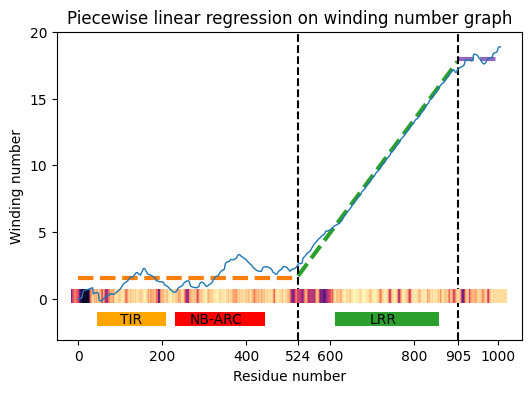

In [4]:
plt.figure(figsize=(6, 4))
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4"])

N = winding.size

# Define the domains
domains = [(46, 210), (231, 445), (611, 859)]
colors = ['orange', 'red', 'C2']
texts = ["TIR", "NB-ARC", "LRR"]
# Draw the domains
rectheight = 1
for domain, color, text in zip(domains, colors, texts):
    start, end = domain
    rect = patches.Rectangle((start, -rectheight*2), end - start, rectheight, facecolor=color)
    plt.gca().add_patch(rect)
    plt.text(start+(end-start)/len(text), -rectheight*1.8, text)
plt.plot([0, N], [0]*2, color='k', linewidth=1)
bfn = bfactor - np.min(bfactor)
bfn /= np.max(bfn)
C = plt.cm.magma(bfn)
for i in range(N-1):
    plt.plot([i, i+1], [0.2, 0.2], c=C[i], linewidth=10)


xticks = list(range(0, 1001, 200)) + breakpoints.tolist()
plt.xticks(xticks);
plt.yticks([0, 5, 10, 15, 20]);
plt.savefig("ClippedRelu_Plot.svg", bbox_inches='tight')

## Make Plot of Annotated Regions in 3D

In [5]:
from mayavi import mlab

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [int(c[1:], 16) for c in colors]
colors = [((c//65536), ((c%65536)//256), (c%256)) for c in colors]

X = loader.structures[protid]
plot_residue_annotations_3d(X, breakpoints, [colors[1], colors[2], colors[4]])
mlab.show()